In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# # Download required NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab') # Download the punkt_tab resource

In [91]:

# Load the uploaded CSV file
file_path = 'review.csv'
data = pd.read_csv(file_path)


In [92]:
data = data[data['stars'] != 0]

In [94]:
# data[['text', 'stars', 'sentiment']]

# Functions

In [11]:
def PreprocessingText(text):
    stop_words = set(stopwords.words('english'))

    if isinstance(text, str):  # Ensure the input is a string
        # Remove HTML tags, special characters, and digits
        text = re.sub(r'&\w+;', ' ', text)  # Remove HTML entities
        text = re.sub(r'<[^>]+>', '', text) # Matches anything between < and >
        text = re.sub(r'\s+', ' ', text)    # Remove extra spaces
        text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
        text = re.sub(r'\d+', '', text)     # Remove numbers

        # Lowercase the text
        text = text.lower()

        # Tokenize and remove stopwords
        words = nltk.word_tokenize(text)
        words = [word for word in words if word not in stop_words]

        # removing HTML tags

        return " ".join(words)
    return text

In [12]:

# Preprocessing function
data['cleaned_text'] = data['text'].apply(PreprocessingText)


In [13]:
data['text'][14] , data['cleaned_text'][14]

('Fantastic, but mild. I added half a Carolina Reaper. Delish! The hubby  said he detested white chili. As this was simmering, hubby said &#34;Boy, that sure smells great! When do we eat?&#34; He asked me to make more to freeze for later. LOL!',
 'fantastic mild added half carolina reaper delish hubby said detested white chili simmering hubby said boy sure smells great eat asked make freeze later lol')

In [14]:
drop_columns = ['Unnamed: 0', 'recipe_number', 'recipe_code', 'recipe_name',
       'comment_id', 'user_id', 'user_name', 'user_reputation', 'created_at',
       'reply_count', 'thumbs_up', 'thumbs_down' , 'best_score']
data = data.drop(columns=drop_columns , axis = 1)

In [95]:
# Create a new column 'sentiment' based on the 'stars' column
# Negative (0) for stars <= 3, Positive (1) for stars > 3
data['sentiment'] = data['stars'].apply(lambda x: 0 if x <= 3 else 1)

# Check the distribution of the new sentiment classes
print(data['sentiment'].value_counts())


sentiment
1    15484
0     1002
Name: count, dtype: int64


In [16]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Ensure NLTK resources are downloaded
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment based on text
def calculate_sentiment(text):
    if isinstance(text, str):  # Ensure the input is a valid string
        score = sia.polarity_scores(text)['compound']
        return 1 if score > 0 else 0  # Positive if compound score > 0, else Negative
    return None

# Apply the function to the 'text' column and create a new 'sentiment' column
# data['sentiment'] = data[data['stars'] == 0]['text'].apply(calculate_sentiment)
data['sentiment_new'] = data['cleaned_text'].apply(calculate_sentiment)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
data = data.dropna(subset=['cleaned_text'])

In [29]:
data[['sentiment' , 'sentiment_new']]

,sentiment,sentiment_new
0,1,1.0
1,1,1.0
2,1,1.0
3,0,0.0
4,0,1.0
...,...,...
18177,1,1.0
18178,1,1.0
18179,1,1.0
18180,1,1.0


In [34]:
data['sentiment'].value_counts()

sentiment
1    15482
0     2698
Name: count, dtype: int64

In [35]:
data['sentiment_new'].value_counts()

sentiment_new
1.0    16449
0.0     1731
Name: count, dtype: int64

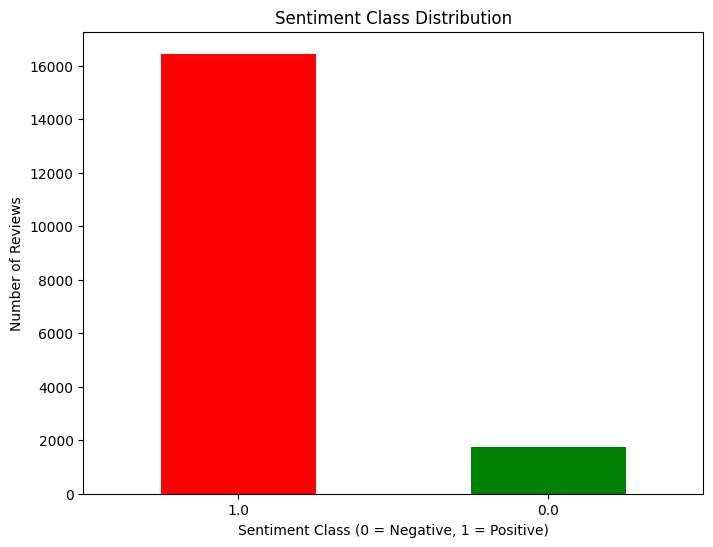

In [31]:

# Check the distribution of the new sentiment classes
sentiment_counts = data['sentiment_new'].value_counts()

# Create a bar graph for sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment Class (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


In [36]:

# Assuming `df` is your DataFrame and `sentiment` is the target column
positive_rows = data[data['sentiment_new'] == 1]  # Filter rows where sentiment is positive
negative_rows = data[data['sentiment_new'] == 0]  # Filter rows where sentiment is negative

positive_rows_to_keep = positive_rows.sample(n=11000, random_state=42)  # Select 7,000 rows to drop
positive_rows = positive_rows.drop(positive_rows_to_keep.index)  # Remove those 7,000 rows

balanced_df = pd.concat([positive_rows, negative_rows])  # Combine reduced positive rows with negative rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle and reset index




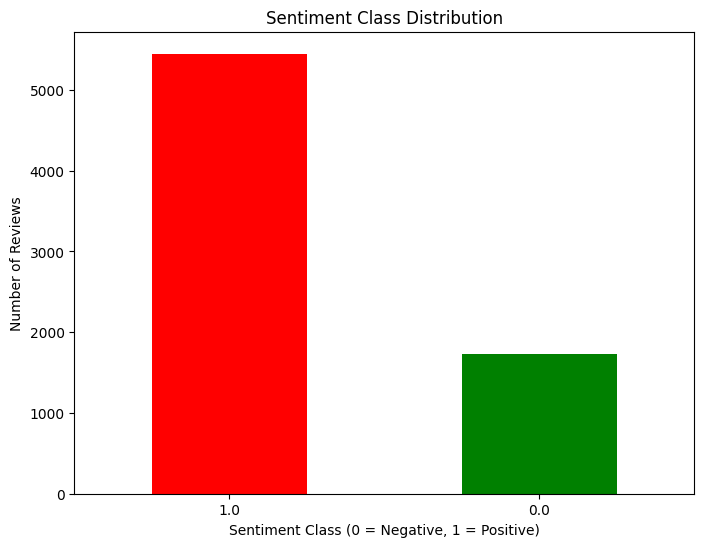

In [37]:

# Check the distribution of the new sentiment classes
sentiment_counts = balanced_df['sentiment_new'].value_counts()

# Create a bar graph for sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment Class (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


In [38]:
balanced_df['cleaned_text'] = balanced_df['cleaned_text'].apply(lambda x: x if isinstance(x, str) else '')

In [39]:
# import pandas as pd
# import torch
# import torch.nn as nn
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences


# # Step 1: Prepare the Data
# # Assuming `balanced_df` is already prepared with columns 'text' (input) and 'sentiment' (target)

# # Tokenization
# max_words = 10000  # Maximum number of words in the tokenizer
# max_len = 100      # Maximum length of sequences

# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(balanced_df['cleaned_text'])  # Fit tokenizer on text data

# # Convert text to sequences
# sequences = tokenizer.texts_to_sequences(balanced_df['cleaned_text'])

# # Pad sequences to ensure uniform length
# X = pad_sequences(sequences, maxlen=max_len)

# y = balanced_df['sentiment'].values  # Target values

# # Step 2: Split the Data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # Step 3: Build the LSTM Model
# class SentimentLSTM(nn.Module):
#     def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
#         super(SentimentLSTM, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_size)
#         self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         x = self.embedding(x)
#         x, (hidden, cell) = self.lstm(x)
#         x = self.dropout(hidden[-1])  # Take the last hidden state
#         x = self.fc(x)
#         return x

# # Model Parameters
# vocab_size = max_words + 1
# embed_size = 128
# hidden_size = 64
# output_size = 2  # Binary classification
# num_layers = 1
# dropout = 0.5

# # Initialize the Model
# model = SentimentLSTM(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout)

# # Define Loss and Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Step 4: Training Loop
# batch_size = 64
# epochs = 5

# def train_model(model, X_train, y_train, criterion, optimizer, epochs, batch_size):
#     model.train()
#     for epoch in range(epochs):
#         epoch_loss = 0
#         for i in range(0, len(X_train), batch_size):
#             batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.long)
#             batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.long)

#             optimizer.zero_grad()
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(X_train)}")

# # Train the Model
# train_model(model, X_train, y_train, criterion, optimizer, epochs, batch_size)

# # Step 5: Evaluate the Model
# def evaluate_model(model, X_test, y_test):
#     model.eval()
#     with torch.no_grad():
#         test_X = torch.tensor(X_test, dtype=torch.long)
#         test_y = torch.tensor(y_test, dtype=torch.long)
#         outputs = model(test_X)
#         predictions = torch.argmax(outputs, dim=1)
#         accuracy = (predictions == test_y).float().mean()
#         print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

# # Evaluate
# evaluate_model(model, X_test, y_test)


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
def build_lstm_model(vocab_size, embed_size, max_len, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_len),
        LSTM(64, return_sequences=False, dropout=dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(2, activation='softmax')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


vocab_size = 10000 + 1  # Same as tokenizer's `num_words`
embed_size = 128
max_len = 100

model = build_lstm_model(vocab_size, embed_size, max_len)
model.summary()


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


# Tokenization
max_words = 10000  # Maximum number of words in tokenizer
max_len = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(balanced_df['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(balanced_df['cleaned_text'])
X = pad_sequences(sequences, maxlen=max_len)  # Pad sequences
y = balanced_df['sentiment'].values  # Labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert data to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.int32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Train the model
history = model.fit(
    X_train_tensor,
    y_train_tensor,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_tensor, y_test_tensor)
)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7800 - loss: 0.5713 - val_accuracy: 0.8099 - val_loss: 0.4650
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8186 - loss: 0.4158 - val_accuracy: 0.8287 - val_loss: 0.3959
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8891 - loss: 0.3129 - val_accuracy: 0.8496 - val_loss: 0.4073
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9177 - loss: 0.2315 - val_accuracy: 0.8377 - val_loss: 0.4341
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9344 - loss: 0.1991 - val_accuracy: 0.8461 - val_loss: 0.4846


In [60]:
import matplotlib.pyplot as plt


def display_plot( history ):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


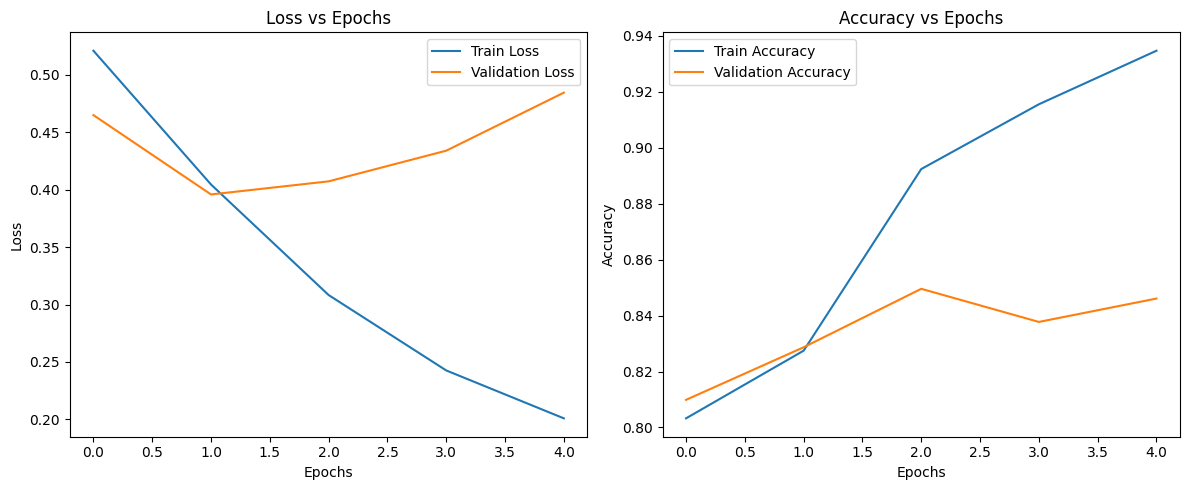

In [43]:
display_plot( history )

## 2nd Try - Tying out work2vec embedding

In [63]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split

# Load your dataset
# Assuming `balanced_df` is a DataFrame with 'cleaned_text' and 'sentiment' columns
# 'cleaned_text' is the preprocessed text and 'sentiment' is the target label (0 or 1)

# Step 1: Preprocess and Tokenize
max_words = 10000  # Maximum vocabulary size
max_len = 100  # Maximum sequence length

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['cleaned_text'])

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(balanced_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Labels
labels = balanced_df['sentiment_new'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels, random_state=42)

# Step 2: Train Word2Vec Model
tokenized_sentences = [sentence.split() for sentence in balanced_df['cleaned_text']]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=64, window=5, min_count=1, workers=4)

# Step 3: Create Embedding Matrix
embedding_dim = 64
embedding_matrix = np.zeros((max_words, embedding_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = word2vec_model.wv[word] if word in word2vec_model.wv else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 4: Build Simple RNN Model with Word2Vec
def build_simple_rnn_with_word2vec(vocab_size, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False  # Freeze embeddings
        ),
        SimpleRNN(64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    return model

# Initialize and compile the model
vocab_size = max_words  # Same as tokenizer's num_words
model = build_simple_rnn_with_word2vec(vocab_size, max_len, embedding_matrix)

# Model summary
model.summary()

# Step 5: Train the Model
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Step 6: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,000 (2.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 640,000 (2.44 MB)

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - auc: 0.5595 - loss: 0.5771 - val_auc: 0.6998 - val_loss: 0.5365
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5861 - loss: 0.5545 - val_auc: 0.4977 - val_loss: 0.5569
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5195 - loss: 0.5606 - val_auc: 0.5128 - val_loss: 0.5521
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.5173 - loss: 0.5514 - val_auc: 0.5242 - val_loss: 0.5513
45/45 - 0s - 5ms/step - auc: 0.6998 - loss: 0.5365
Test Loss: 0.5365, Test Accuracy: 0.6998


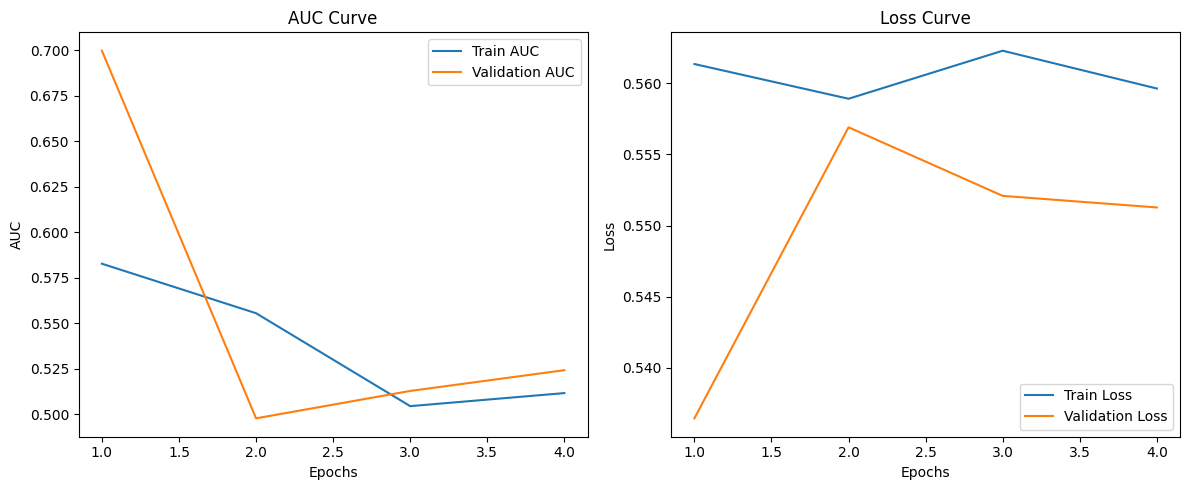

In [64]:
import matplotlib.pyplot as plt

# Plot AUC and Loss Curves
def plot_training_curves(history):
    # Extract data
    auc_train = history.history['auc']
    auc_val = history.history['val_auc']
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(auc_train) + 1)
    
    # Create subplots
    plt.figure(figsize=(12, 5))
    
    # AUC Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, auc_train, label='Train AUC')
    plt.plot(epochs, auc_val, label='Validation AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_train, label='Train Loss')
    plt.plot(epochs, loss_val, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot curves
plot_training_curves(history)


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

def build_simple_rnn_with_word2vec(vocab_size, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False  # Freeze embeddings to use pre-trained Word2Vec
        ),
        SimpleRNN(64),  # Simple RNN layer
        Dense(32, activation='relu'),
        Dropout(0.5),  # Add dropout for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

# Assuming `vocab_size`, `max_len`, and `embedding_matrix` are already defined
model = build_simple_rnn_with_word2vec(vocab_size, max_len, embedding_matrix)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,107,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,107,840 (4.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,107,840 (4.23 MB)

In [51]:
from gensim.models import Word2Vec
import numpy as np


# Build the model
model = build_simple_rnn_with_word2vec(vocab_size, max_len, embedding_matrix)


NameError: name 'train_sentences' is not defined

In [ ]:
display_plot( history )

## Remeving work2Vec and adding more simplification

In [48]:


# # Define LSTM model with regularization
# def build_lstm_model(vocab_size, embed_size, max_len, dropout_rate=0.5, l2_lambda=0.01):
#     model = Sequential([
#         Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_len),
#         LSTM(64, return_sequences=False, dropout=dropout_rate, recurrent_dropout=0.5, kernel_regularizer=l2(l2_lambda)),
#         Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
#         Dropout(dropout_rate),
#         Dense(2, activation='softmax')  # Binary classification
#     ])
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Model parameters
# vocab_size = 10000 + 1  # Same as tokenizer's num_words + 1 for OOV token
# embed_size = 128

# # Build and summarize the model
# model = build_lstm_model(vocab_size, embed_size, max_len)
# model.summary()




In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


# Define a simple RNN model
model = Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64),  # Embedding layer
    tf.keras.layers.SimpleRNN(64),  # Simple RNN layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)
# Model summary
model.summary()



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model = Sequential([
#     tf.keras.layers.Embedding(10000, 32), 
#     tf.keras.layers.SimpleRNN(32, kernel_regularizer = tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


# model.compile( loss="binary_crossentropy", optimizer="adam",     metrics=['accuracy', AUC(name='auc')] )

In [77]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


# Tokenization
max_words = 10000  # Maximum number of words in tokenizer
max_len = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(balanced_df['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(balanced_df['cleaned_text'])
X = pad_sequences(sequences, maxlen=max_len)  # Pad sequences
y = balanced_df['sentiment'].values  # Labels

print("Padding Sequence: ", X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert data to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.int32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)



Padding Sequence:  [[  0   0   0 ... 268 171 184]
 [  0   0   0 ...  86   1 256]
 [  0   0   0 ... 167  42 521]
 ...
 [  0   0   0 ...   1 100 313]
 [  0   0   0 ...  95 359   9]
 [  0   0   0 ... 226  39   3]]


In [78]:

# Train the model
history = model.fit(
    X_train_tensor,
    y_train_tensor,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_tensor, y_test_tensor),
    callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7481 - auc: 0.5119 - loss: 0.5451 - val_accuracy: 0.8099 - val_auc: 0.6111 - val_loss: 0.4792
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8138 - auc: 0.8595 - loss: 0.4229 - val_accuracy: 0.8001 - val_auc: 0.6286 - val_loss: 0.4802
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9126 - auc: 0.9566 - loss: 0.2530 - val_accuracy: 0.7855 - val_auc: 0.6531 - val_loss: 0.4964
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9733 - auc: 0.9933 - loss: 0.1027 - val_accuracy: 0.7883 - val_auc: 0.6615 - val_loss: 0.5496


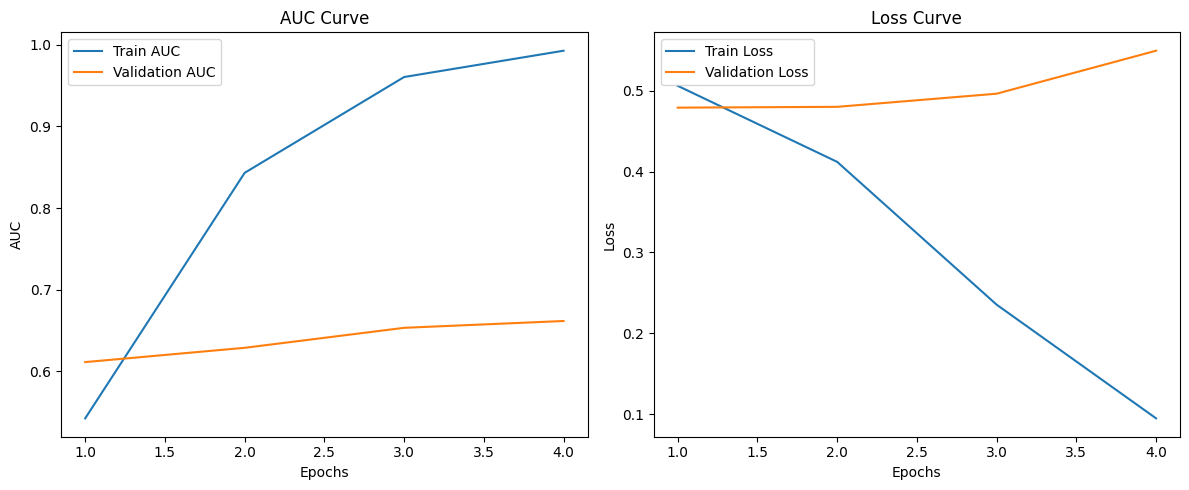

In [79]:
import matplotlib.pyplot as plt

# Plot AUC and Loss Curves
def plot_training_curves(history):
    # Extract data
    auc_train = history.history['auc']
    auc_val = history.history['val_auc']
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(auc_train) + 1)
    
    # Create subplots
    plt.figure(figsize=(12, 5))
    
    # AUC Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, auc_train, label='Train AUC')
    plt.plot(epochs, auc_val, label='Validation AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_train, label='Train Loss')
    plt.plot(epochs, loss_val, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot curves
plot_training_curves(history)


In [84]:
from sklearn.metrics import confusion_matrix

# After model predictions
predictions = (model.predict(X_test_tensor) > 0.5).astype("int32")
cm = confusion_matrix(y_test, predictions)

print("Confusion Matrix:")
print(cm)


ValueError: X has 100 features, but GradientBoostingClassifier is expecting 10000 features as input.

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
def preprocess_text(text, tokenizer, max_len):
    """
    Tokenizes and pads the input text.
    
    Args:
        text (str): The input text to predict.
        tokenizer (Tokenizer): The tokenizer used during training.
        max_len (int): The maximum length for padding.

    Returns:
        np.array: The preprocessed and padded input ready for prediction.
    """
    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    return padded_sequence

def predict_text(text, model, tokenizer, max_len):
    """
    Predicts the sentiment for a given text using the trained model.
    
    Args:
        text (str): The input text to predict.
        model (Model): The trained model.
        tokenizer (Tokenizer): The tokenizer used during training.
        max_len (int): The maximum length for padding.

    Returns:
        float: The predicted probability of the positive class.
    """
    # Preprocess the input text
    preprocessed_text = preprocess_text(text, tokenizer, max_len)
    # Make a prediction
    prediction = model.predict(preprocessed_text)
    return prediction[0][0]  # Assuming binary classification with sigmoid activation


In [ ]:
# Example input text
input_text = """
Absolutely horrible. I don't like it
"""

# Predict sentiment
predicted_probability = predict_text(input_text, model, tokenizer, max_len)

# Interpret the prediction
if predicted_probability >= 0.5:
    print(f"Positive sentiment ({predicted_probability:.2f})")
else:
    print(f"Negative sentiment ({predicted_probability:.2f})")


## graident Boosting Algo

In [82]:
balanced_df.shape

(7180, 5)

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Assuming `balanced_df` has columns 'cleaned_text' and 'sentiment'
# Step 1: Prepare the data
X = balanced_df['cleaned_text']  # Text data
y = balanced_df['sentiment_new']     # Labels (0 or 1)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 4: Train the Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_tfidf, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       346
         1.0       0.95      0.93      0.94      1090

    accuracy                           0.92      1436
   macro avg       0.88      0.90      0.89      1436
weighted avg       0.92      0.92      0.92      1436

ROC-AUC Score: 0.9454
Confusion Matrix:
[[ 298   48]
 [  72 1018]]


In [ ]:
[[ 279   67]
 [  73 1017]]

[[ 298   48]
 [  72 1018]]

## Testing

In [86]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np

(train_data, test_data), info = tfds.load(
    'imdb_reviews',
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
    as_supervised=True,
    with_info=True
)

# Tokenize and pad the reviews
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
train_sentences, train_labels = zip(*[(sent.numpy().decode('utf8'), label.numpy()) for sent, label in train_data])
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')

test_sentences, test_labels = zip(*[(sent.numpy().decode('utf8'), label.numpy()) for sent, label in test_data])
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Dell\tensorflow_datasets\imdb_reviews\plain_text\incomplete.7H6Q87_1.0.0\imdb_reviews-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Dell\tensorflow_datasets\imdb_reviews\plain_text\incomplete.7H6Q87_1.0.0\imdb_reviews-test.…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Dell\tensorflow_datasets\imdb_reviews\plain_text\incomplete.7H6Q87_1.0.0\imdb_reviews-unsup…

Dataset imdb_reviews downloaded and prepared to C:\Users\Dell\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
